In [13]:
# Launch this in conda environment titled "myenv"
import pandas as pd
import numpy as np
import layoutparser as lp
from pdf2image import convert_from_path
import cv2
import re
from itertools import chain

from PIL import Image
import pytesseract
import os

## Introduction

Convert the .pdf's to actual images (.jpg). This serves as input to the layout detection model. 

In [2]:
def concatenate_short_strings(strings, k):
    i = 1
    while i < len(strings):
        if len(strings[i]) < k:
            strings[i-1] += strings[i]
            del strings[i]
        else:
            i += 1

In [7]:
# Convert to JPG from source
first_page=1
last_page=5

images = convert_from_path('../data/PARIS_1867_Italy.pdf', first_page=first_page, last_page=last_page)

for count, image in enumerate(images, start=first_page):
    image.save(f'../data/Paris1867_Italy_{count}.jpg', 'JPEG')

## Benchmark

Try the tesseract engine without bothering about the layout

In [115]:
# Pick a page and import it
example=101

image = cv2.imread(f"Paris1855_{example}.jpg")
# Convert the image from BGR (cv2 default loading style)
# to RGB
image = image[..., ::-1]
    

In [116]:
# Engage in layout detection
model = lp.Detectron2LayoutModel(
            config_path ='lp://HJDataset/retinanet_R_50_FPN_3x/config', # In model catalog
            label_map   ={0: "Text", 1: "Title", 2: "List", 3:"Table", 4:"Figure"}, # In model`label_map`
            extra_config=["MODEL.ROI_HEADS.SCORE_THRESH_TEST", 0.8] # Optional
        )    


The checkpoint state_dict contains keys that are not used by the model:
  anchor_generator.cell_anchors.{0, 1, 2, 3, 4}


In [117]:
# Use the image detector
layout = model.detect(image)

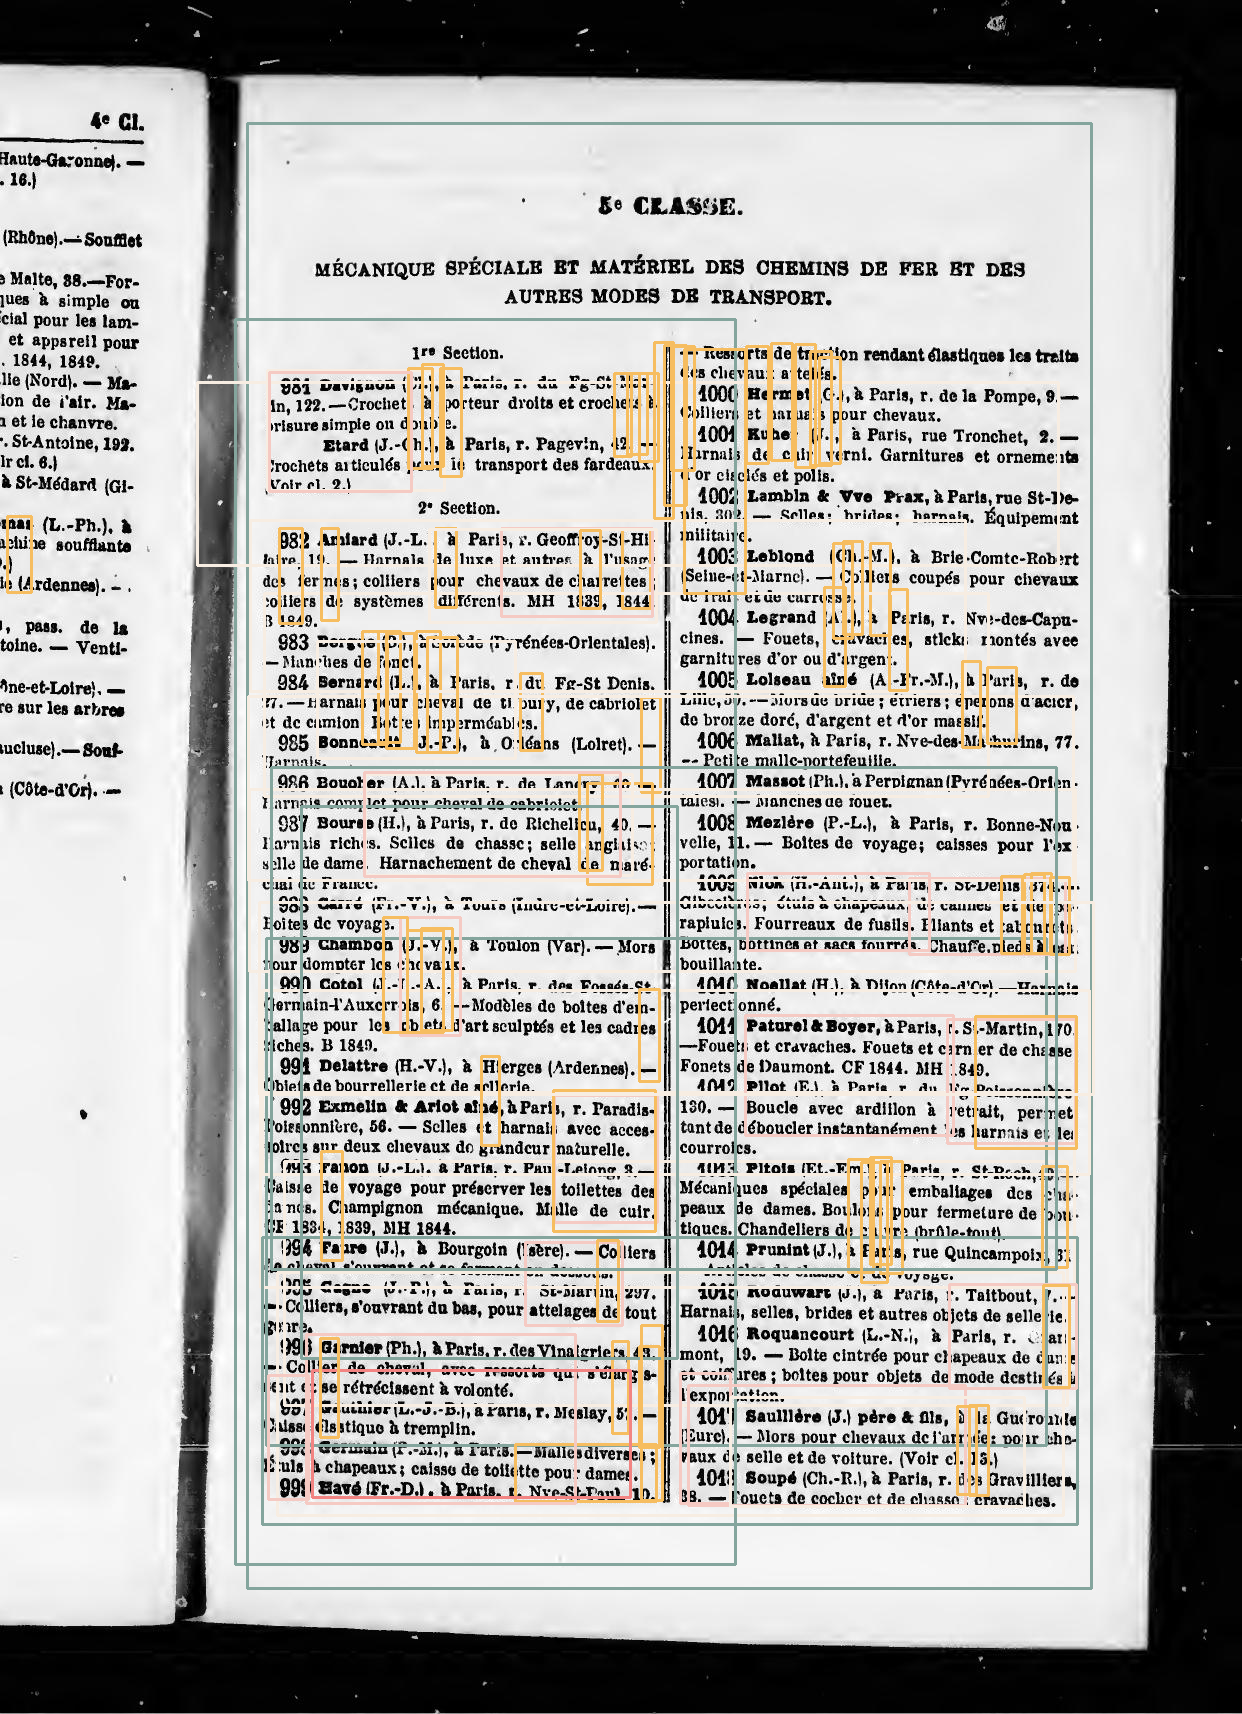

In [121]:
# Draw a box to see what has been detected
lp.draw_box(image, layout, box_width=3)

In [21]:
# test the OCR agent on a particular block
ocr_agent = lp.TesseractAgent(languages='fra')
block = layout[0]

segment_image = (block
                       .pad(left=5, right=5, top=5, bottom=5)
                       .crop_image(image))

In [22]:
ocred_text = ocr_agent.detect(segment_image)
raw_text = block.set(text=ocred_text, inplace=True).text

In [110]:
# Post-processing, extract by patterns of numbers
lines = re.split(r'\n\n', raw_text)
lines[:10]

['€hine à nettoyer le Lié et le décurti.ner sans perte',
 'de lorlne,',
 '4304 doly-Villenet IN.1. h Ay (Marnit, — Puble\nnet à double oriteu; rubliet à vrllice mobile ct à\nsiphon.',
 "4305 Lañargue 1Fr., à l'rayaane dati. Mouble\n&e presse nextenire l'hulle dengralnes olduennes.",
 'Lapique 1.11, il Maxdvihe pieurther,',
 "Moulin à D'é. Vtt el, 14.)",
 '4306 Laplanche (t\nMoilete de',
 '4307 Lebtsre ;S1.. V1, à Mautivilllers Seine-1n-\nfleur, — Muchirée à vapeur punr Lattre les cd-\nréales.',
 "4308 Lefèvre IFr.-Ant.-1.i, & l'Adeuit, à Pou-\ntolse pSene-et-Uiset. — Menle de moulin, Système\npour rufrulchlr les meutes et lu mouture duns lus\nmoulins à farine,",
 '4209 Lefranc-Thirion, à lsr-le-Dne (Meuse, —\nBrosseur mwérunique panr le net Le des gratis.']

In [52]:
# Now the general pipeline

# 1. Make an object to store the output lines in
output = list()

# 2. Convert the images to JPG from source
first_page=100
last_page=110

images = convert_from_path('Paris1855.pdf', first_page=first_page, last_page=last_page)

for count, image in enumerate(images, start=first_page):
    image.save(f'Paris1855_{count}.jpg', 'JPEG')
    

# 3. For loop over the images:
# Pick a page and import it
for i in range(first_page, last_page):
    image = cv2.imread(f"Paris1855_{i}.jpg")
    # Convert the image from BGR (cv2 default loading style)
    # to RGB
    image = image[..., ::-1]
    # Use the image detector
    layout = model.detect(image)
    # Find the block with the highest confidence score 
    block = max(layout, key=lambda x: x.score)
    # Crop the image to the block to reduce noise but keep a buffer
    segment_image = (block
                       .pad(left=5, right=5, top=5, bottom=5)
                       .crop_image(image))
    # OCR it and keep the text
    ocred_text = ocr_agent.detect(segment_image)
    # Split it up in separate lines (observations)
    # lines = re.split(r'\n\n', raw_text)
    # Add it to output
    output.append(ocred_text)
    

In [60]:
# put everything together
longstring = " ".join(output)

In [91]:
# concatenate_short_strings(pr, 40)
data = re.split(r'\n\n|\n\d{2,4}', longstring)

In [135]:
# to df
df = pd.DataFrame([i for i in data if len(i) > 10],
                  columns=['string'])


In [137]:
df.to_csv('data.csv', index=False)